# 여러 개의 이미지를 분류하는 다층 신경망

다중 분류 신경망을 만들기 위해 소프트맥스 함수와 크로스 엔트로피 손실함수라는   
새로운 재료를 알아야 한다.  
자동차 분류를 통해 다중 분류를 위한 신경망과 이진분류를 위한 신경망의  
차이점에 대해 알아보자





## 다중 분류 신경망
아래 사진은 이진 분류에서 사용된 다층 신경망의 구조를 나타낸 것이다.  
이진 분류를 위해 출력층에는 뉴런을 하나만 두었다.  
출력층의 활성화 값이 0.5보타 크면 양성, 그렇지 않으면 음성으로 분류했다.

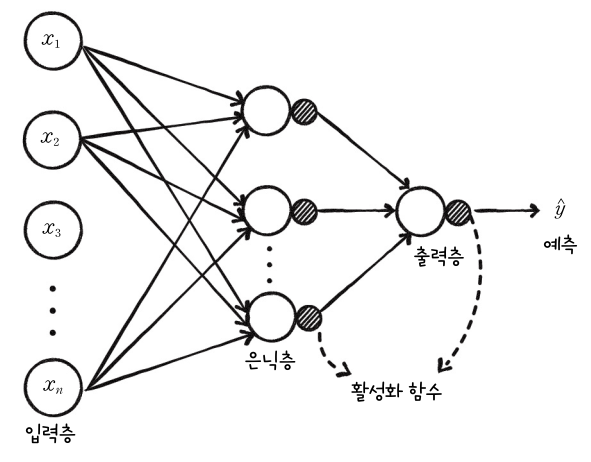



다중 분류를 만들려면 출력층을 여러개로 늘리는 방법이 있다.  
다중 분류의 출력층에는 분류할 클래스 개수만큼 뉴런을 배친한다.  

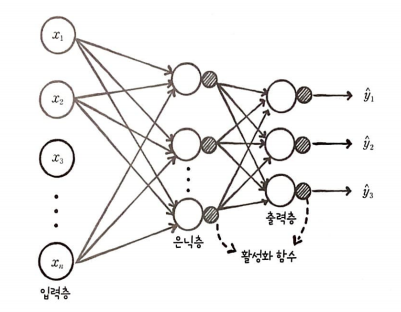

## 다중 분류의 문제점과 소프트맥스 함수
다음은 자동차, 비행기, 로켓 이미지를 분류하는 다중 분류 신경망의  
출력층만 나타낸 것이다.  
왼쪽의 값은 0.9, 0.8, 0.7 이고 오른쪽은 0.5, 0.2, 0.1이다.
이 값들은 확률을 나타낸다.  
아래 그림 왼쪽에서, 0.9라는 것은 자동차일 확률이 90%라는걸 뜻한다.  

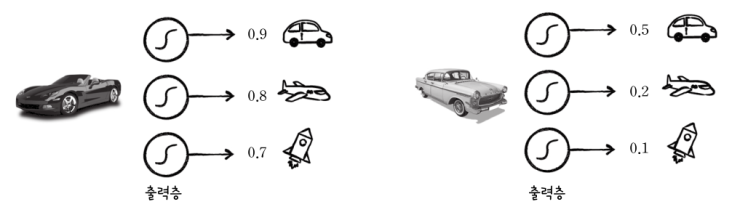



그런데 좌우 모두 자동차를 타깃으로 예측을 하고 있기는 한데  
왼쪽은 전체적으로 값이 높지만 오른쪽은 전체적으로 값이 낮다.  
</br>

### 활성화 출력의 합이 1이 아니면 비교하기 어렵다.
위 그림에서, 더 잘 예측한 것은 오른쪽이라고 할 수 있다.  
왜냐하면 왼쪽의 경우, 가장 높은 값과 두 번째로 높은 값간의 차이가  
너무 적은 반면, 오른쪽은 가장 높은 값과 두 번째로 높은 값의 차이가  
2.5배나 나기 때문이다.  
때문에 위와 같은 출력은 공정하게 비교하기 어렵다.  
  
</br>

### 소프트맥스 함수를 적용해 출력 강도를 정규화 한다.

정규화란 전체 출력값의 합을 1로 만든다는 의미다.  
이렇게 하면 훨씬 나은 형태로 값을 비교할 수 있다.  
위 예제를 정규화 하면 다음과 같은 값이 나온다.
  
시그모이드 함수의 공식은 (1 / (1+e^-z)) 이다.  
이를 z에 대해 정리하면 z = -ln(1/y - 1) 이 된다.  

이 식을 정리하여 앞선 식에 적용하면 다음과 같은 값을 얻을 수 있다.  

2.20, 1.39, 0.85  
0.00, -1.39. -2.20

이 값들을 아래 소프트 맥스 함수에 대입해보자




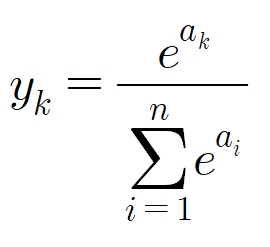

위 사진은 소프트 맥스 함수이다.  
소프트 맥스 함수에 앞서 구한 값을 넣으면 다음과 같은 값을 얻을 수 있다.  
  
0.59, 0.26, 0.15  
0.74, 0.18, 0.08  
  
값의 합이 1이 되니 비교하기가 더 좋아졌다.  
  
</br>


# 다층 분류 신경망 구현
  
다중 분류 경사 하강법 알고리즘은 이진 분류의 경사 하강 알고리즘과 원리만 같고  
소프트 맥스 함수가 추가된 점만 다르므로 이 부분만 손보면 간단히 구현할 수 있다.  

In [1]:
# 넘파이 임포트
import numpy as np

In [ ]:
class MultiClassNetwork:
    
    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
        self.units = units         # 은닉층의 뉴런 개수
        self.batch_size = batch_size     # 배치 크기
        self.w1 = None             # 은닉층의 가중치
        self.b1 = None             # 은닉층의 절편
        self.w2 = None             # 출력층의 가중치
        self.b2 = None             # 출력층의 절편
        self.a1 = None             # 은닉층의 활성화 출력
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터

    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1        # 첫 번째 층의 선형 식을 계산합니다
        self.a1 = self.sigmoid(z1)               # 활성화 함수를 적용합니다
        z2 = np.dot(self.a1, self.w2) + self.b2  # 두 번째 층의 선형 식을 계산합니다.
        return z2

    def backprop(self, x, err):
        m = len(x)       # 샘플 개수
        # 출력층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        # 시그모이드 함수까지 그래디언트를 계산합니다.
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        # 은닉층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad
    
    def sigmoid(self, z):
        z = np.clip(z, -100, None)            # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))              # 시그모이드 계산
        return a
    
    def softmax(self, z):
        # 소프트맥스 함수
        z = np.clip(z, -100, None)            # 안전한 np.exp() 계산을 위해
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)
 
    def init_weights(self, n_features, n_classes):
        self.w1 = np.random.normal(0, 1, 
                                   (n_features, self.units))  # (특성 개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)                        # 은닉층의 크기
        self.w2 = np.random.normal(0, 1, 
                                   (self.units, n_classes))   # (은닉층의 크기, 클래스 개수)
        self.b2 = np.zeros(n_classes)
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        np.random.seed(42)
        self.init_weights(x.shape[1], y.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs):
            loss = 0
            print('.', end='')
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            for x_batch, y_batch in self.gen_batch(x, y):
                a = self.training(x_batch, y_batch)
                # 안전한 로그 계산을 위해 클리핑합니다.
                a = np.clip(a, 1e-10, 1-1e-10)
                # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
                loss += np.sum(-y_batch*np.log(a))
            self.losses.append((loss + self.reg_loss()) / len(x))
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)

    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size # 미니배치 횟수
        if length % self.batch_size:
            bins += 1                    # 나누어 떨어지지 않을 때
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.
            
    def training(self, x, y):
        m = len(x)                # 샘플 개수를 저장합니다.
        z = self.forpass(x)       # 정방향 계산을 수행합니다.
        a = self.softmax(z)       # 활성화 함수를 적용합니다.
        err = -(y - a)            # 오차를 계산합니다.
        # 오차를 역전파하여 그래디언트를 계산합니다.
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # 그래디언트에서 페널티 항의 미분 값을 뺍니다
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        # 은닉층의 가중치와 절편을 업데이트합니다.
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        # 출력층의 가중치와 절편을 업데이트합니다.
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a
   
    def predict(self, x):
        z = self.forpass(x)          # 정방향 계산을 수행합니다.
        return np.argmax(z, axis=1)  # 가장 큰 값의 인덱스를 반환합니다.
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == np.argmax(y, axis=1))

    def reg_loss(self):
        # 은닉층과 출력층의 가중치에 규제를 적용합니다.
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)            # 정방향 계산을 수행합니다.
        a = self.softmax(z)                # 활성화 함수를 적용합니다.
        a = np.clip(a, 1e-10, 1-1e-10)     # 출력 값을 클리핑합니다.
        # 크로스 엔트로피 손실과 규제 손실을 더하여 리스트에 추가합니다.
        val_loss = np.sum(-y_val*np.log(a))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))